## Install dependencies

In [1]:
# We should install these modules for our notebook to function.
!pip install --quiet --upgrade pip
!pip install --quiet numpy pandas matplotlib tensorflow scikit-learn seaborn lightgbm watermark

## Imports

In [2]:
# Import required libraries
import numpy as np  # mathematical operations
import pandas as pd  # data manipulation
import seaborn as sns  # data visualization
import matplotlib.pyplot as plt  # plotting
import tensorflow as tf  # building the machine learning model.
from watermark import watermark # printing package version information

#import necessary modules
from tensorflow import keras  # for building neural networks using TensorFlow
from sklearn.metrics import roc_auc_score  # calculates ROC AUC score
from sklearn.tree import DecisionTreeRegressor # for building decision tree regressors
from sklearn.preprocessing import OneHotEncoder  # for one-hot encoding categorical features
from sklearn.neighbors import LocalOutlierFactor  # detecting outliers
from sklearn.model_selection import GridSearchCV  # hyperparameter tuning
from sklearn.model_selection import train_test_split  # splitting data
from sklearn.ensemble import GradientBoostingClassifier  # for building gradient boosting classifiers
from sklearn.feature_selection import mutual_info_regression  # for performing mutual information feature selection


# built-in modules
import random

# set the global style for matplotlib plots
sns.set_style("dark")

# set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)


## Infromation About Environment

In [3]:
print(watermark()) # print general system information

Last updated: 2023-04-26T10:02:30.721649+00:00

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.34.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.15.90+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [4]:
print(watermark(packages="numpy,scipy,sklearn,seaborn,tensorflow,pandas,matplotlib"))

numpy     : 1.21.6
scipy     : 1.7.3
sklearn   : 1.0.2
seaborn   : 0.12.2
tensorflow: 2.11.0
pandas    : 1.3.5
matplotlib: 3.5.3



In [5]:
!nvidia-smi # print GPU information

Wed Apr 26 10:02:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!free -h # print RAM information

              total        used        free      shared  buff/cache   available
Mem:           15Gi       1.2Gi       7.6Gi       0.0Ki       6.7Gi        14Gi
Swap:            0B          0B          0B


## Load and preprocess the dataset

In [7]:
# Read in the train.csv, healthcare-dataset-stroke-data.csv, and test.csv files as pandas data frames
df = pd.read_csv("/kaggle/input/playground-series-s3e2/train.csv")
original = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
test_df = pd.read_csv("/kaggle/input/playground-series-s3e2/test.csv")

# Concatenate the training data and additional data frames along the 0 axis
df = pd.concat([df, original], axis=0)

# Modify the 'gender' column of the df and test_df data frames
df['gender'] = np.where(df['gender']=='Other', np.random.choice(['Male', 'Female']), df['gender'])
test_df['gender'] = np.where(test_df['gender']=='Other', np.random.choice(['Male', 'Female']), test_df['gender'])

df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [8]:
# print the shape of the data frame
df.shape

(20414, 12)

In [9]:
# print the first few rows of the data frame
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [10]:
# lets check for nan values in the train and validation data
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [11]:
# lets check for nan values in the test set
test_df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

In [12]:
# With scikit-learn library lets build a decision tree regression model to predict missing values in the bmi.
desicion_tree_regressor = DecisionTreeRegressor(random_state=seed)

# Create a new data frame with columns for age, gender, and bmi
X = df[['age','gender','bmi']].copy()

# Convert gender to a binary value (0 for male and 1 for female)
X.gender = X.gender.replace({'Male':0,'Female':1}).astype(np.uint8)

# Identify rows where bmi is missing and store in missing_rows
nan_bmi_rows = X.bmi.isna()
missing_rows = X[nan_bmi_rows]

# Remove rows with missing bmi values from X and store remaining values in y
X = X[~nan_bmi_rows]
y = X.pop('bmi')

desicion_tree_regressor.fit(X,y) # fitting
predictions = desicion_tree_regressor.predict(missing_rows[['age','gender']]) # predict missing bmi values

# Store predicted bmi values in a pandas Series with the same index as missing_rows
predicted_bmi = pd.Series(predictions, index=missing_rows.index)
df.loc[missing_rows.index,'bmi'] = predicted_bmi # Update the df data frame with the predicted bmi values


In [13]:
# now that we filled the empty values, lets verify
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [14]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.100000,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,30.068182,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.300000,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.800000,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.800000,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.192157,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


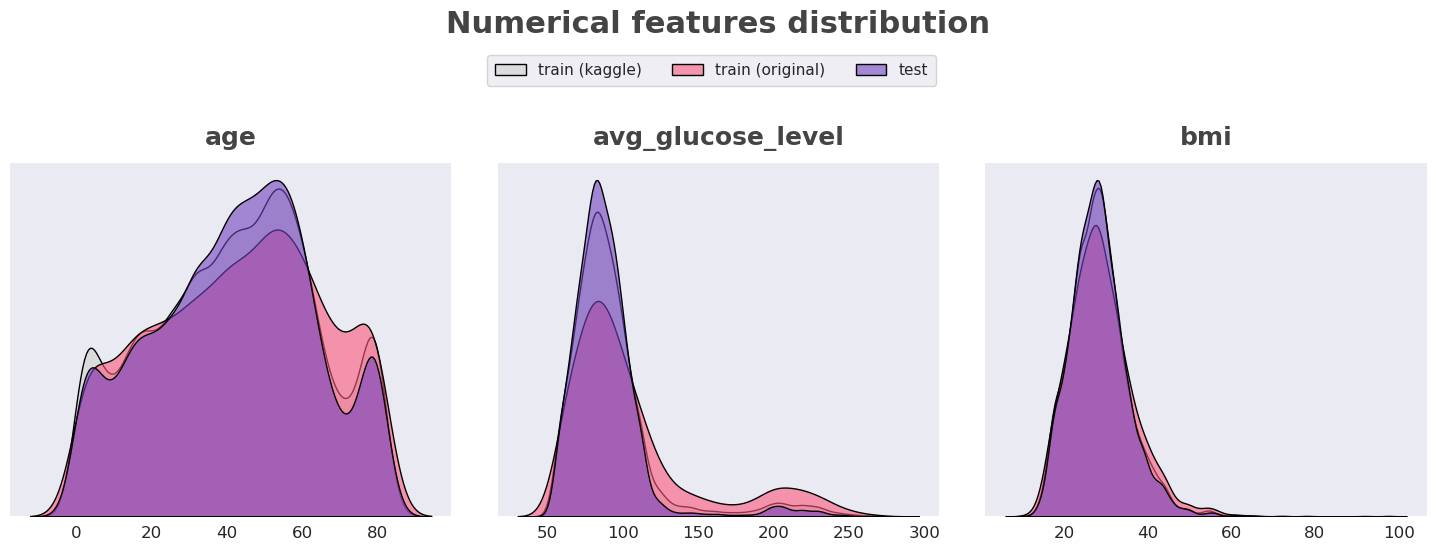

In [15]:
fig = plt.figure(figsize = (15, 5))  # Create a new figure

# Define a list of numerical column names
num_cols = [
    "age",
    "avg_glucose_level",
    "bmi"
]

for i, col in enumerate(num_cols): # Iterate over the numerical columns
    plt.subplot(1,3,i+1) # Create a subplot for each column
    
    # Set the subplot title with specific font properties
    plt.title(col, size=18, y=1.03, fontname='Calibri', 
              fontweight='bold', color='#444444')
    
    # Plot a KDE distribution for the column on the Kaggle training set
    a = sns.kdeplot(df[col], color='#d1d1d1', 
                    fill=True, label='train kaggle', 
                    alpha=0.6, edgecolor='black')
    
    # Plot a KDE distribution for the column on the original training set
    sns.kdeplot(original[col], color='#fb587e', 
                fill=True, label='train original', 
                alpha=0.6, edgecolor='black')
    
    # Plot a KDE distribution for the column on the test set
    sns.kdeplot(test_df[col], color='#7343c1', 
                fill=True, label='test', 
                alpha=0.6, edgecolor='black')
    
    # Remove the axis labels
    plt.ylabel('')
    plt.xlabel('')
    
    plt.xticks(fontname='Calibri', size=12)   # set the font properties for the x-axis tick labels
    plt.yticks([])  # remove the y-axis ticks
    
    # Hide the spines of the subplot
    for s in ['right', 'top', 'left', 'bottom']:
        a.spines[s].set_visible(False)

fig.tight_layout(pad=3) # adjust the layout of the subplots

# Add a legend
fig.legend(['train (kaggle)', 'train (original)', 'test'], bbox_to_anchor=(0.65, 1.07), 
           ncol=3, borderpad=0.5, frameon=True, fontsize=11, title_fontsize=12)

# Add a title
plt.figtext(0.5, 1.1, 'Numerical features distribution', 
            fontname='Calibri', fontweight='bold',
            size=22, color='#444444', ha='center') 

plt.show()

## Feature Engineering

In [16]:
# Define the bins and labels for glucose level categories
bins = [0, 100, 126, 300 ]
labels=['normal','pre-diabetic','diabetic']

# Generate a new categorical column called glucose_levels in the df data frame,
# by binning the avg_glucose_level values into the specified categories
df['glucose_levels'] = pd.cut(df['avg_glucose_level'], bins, labels=labels)

# Same for the test df
test_df['glucose_levels'] = pd.cut(test_df['avg_glucose_level'], bins, labels=labels)


In [17]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,glucose_levels
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.100000,never smoked,0,normal
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,30.068182,formerly smoked,0,normal
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.300000,Unknown,0,pre-diabetic
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.800000,never smoked,0,normal
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.800000,never smoked,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.192157,never smoked,0,normal
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0,pre-diabetic
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0,normal
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0,diabetic


In [18]:
# Define the bins and labels for BMI categories
bins = [0, 25, 30, 40, 100]
labels=['normal','overweight','obese', 'obese1']

# Generate a new categorical column called bmi_category in the df data frame,
# by binning the bmi values into the specified categories
df['bmi_category'] = pd.cut(df['bmi'], bins, labels=labels)

# Same for the test df
test_df['bmi_category'] = pd.cut(test_df['bmi'], bins, labels=labels)


In [19]:
# Define a function to calculate the risk factor for each row in the data frames
def calculate_risk(x):
    glucose_risk = 1 if x.glucose_levels in [2,3] else 0  # Assign glucose risk value based on glucose level category
    bmi_risk = 1 if x.bmi in [2,3,4] else 0  # Assign BMI risk value based on BMI category
    age_risk = 1 if x.age in [2,3] else 0  # Assign age risk value based on age category
    hypertension_risk = 1 if x.hypertension == 1 else 0  # Assign hypertension risk value based on hypertension status
    heart_disease_risk = 1 if x.heart_disease == 1 else 0  # Assign heart disease risk value based on heart disease status
    smoking_status_risk = 1 if x.smoking_status in ['formerly smoked', 'smokes'] else 0  # Assign smoking status risk value based on smoking status
    
    # let's calculate the total risk factor
    total_risk = glucose_risk + bmi_risk + age_risk + hypertension_risk + heart_disease_risk + smoking_status_risk
    return total_risk

# Apply the calculate_risk function to each row in the df data frame, and assign the result to a new column called 'risk factor'
df['risk factor'] = df.apply(calculate_risk, axis=1)

# Do it for the test_df
test_df['risk factor'] = test_df.apply(calculate_risk, axis=1)


In [20]:
# Define a function called generate_features which takes a DataFrame as input
def generate_features(df): 
    # Create three new columns in the DataFrame by performing arithmetic operations on existing columns
    df['age/bmi'] = df.age / df.bmi
    df['age*bmi'] = df.age * df.bmi
    df['bmi/prime'] = df.bmi / 25
#   df['obesity'] = df.avg_glucose_level * df.bmi / 1000
    df['blood_heart']= df.hypertension*df.heart_disease
    return df

# Call the generate_features function on the df DataFrame and store the modified DataFrame in df
df = generate_features(df)
# Same for the test_df
test_df = generate_features(test_df)

In [21]:
# Define a list of categorical features to analyze
cat_features = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
    "bmi_category",
    "glucose_levels",
]

for feat in cat_features:  # Loop through each categorical feature in the list
    unique_values = df[feat].unique()   # Get the unique values of the current feature in the dataset
    print("Feature: ", feat, f"({len(unique_values)})")  # Print the name of the current feature and the number of unique values it has
    print(unique_values) # Print the unique values of the current feature
    print()


Feature:  gender (2)
['Male' 'Female']

Feature:  ever_married (2)
['Yes' 'No']

Feature:  work_type (5)
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Feature:  Residence_type (2)
['Urban' 'Rural']

Feature:  smoking_status (4)
['never smoked' 'formerly smoked' 'Unknown' 'smokes']

Feature:  bmi_category (4)
['obese', 'obese1', 'overweight', 'normal']
Categories (4, object): ['normal' < 'overweight' < 'obese' < 'obese1']

Feature:  glucose_levels (3)
['normal', 'pre-diabetic', 'diabetic']
Categories (3, object): ['normal' < 'pre-diabetic' < 'diabetic']



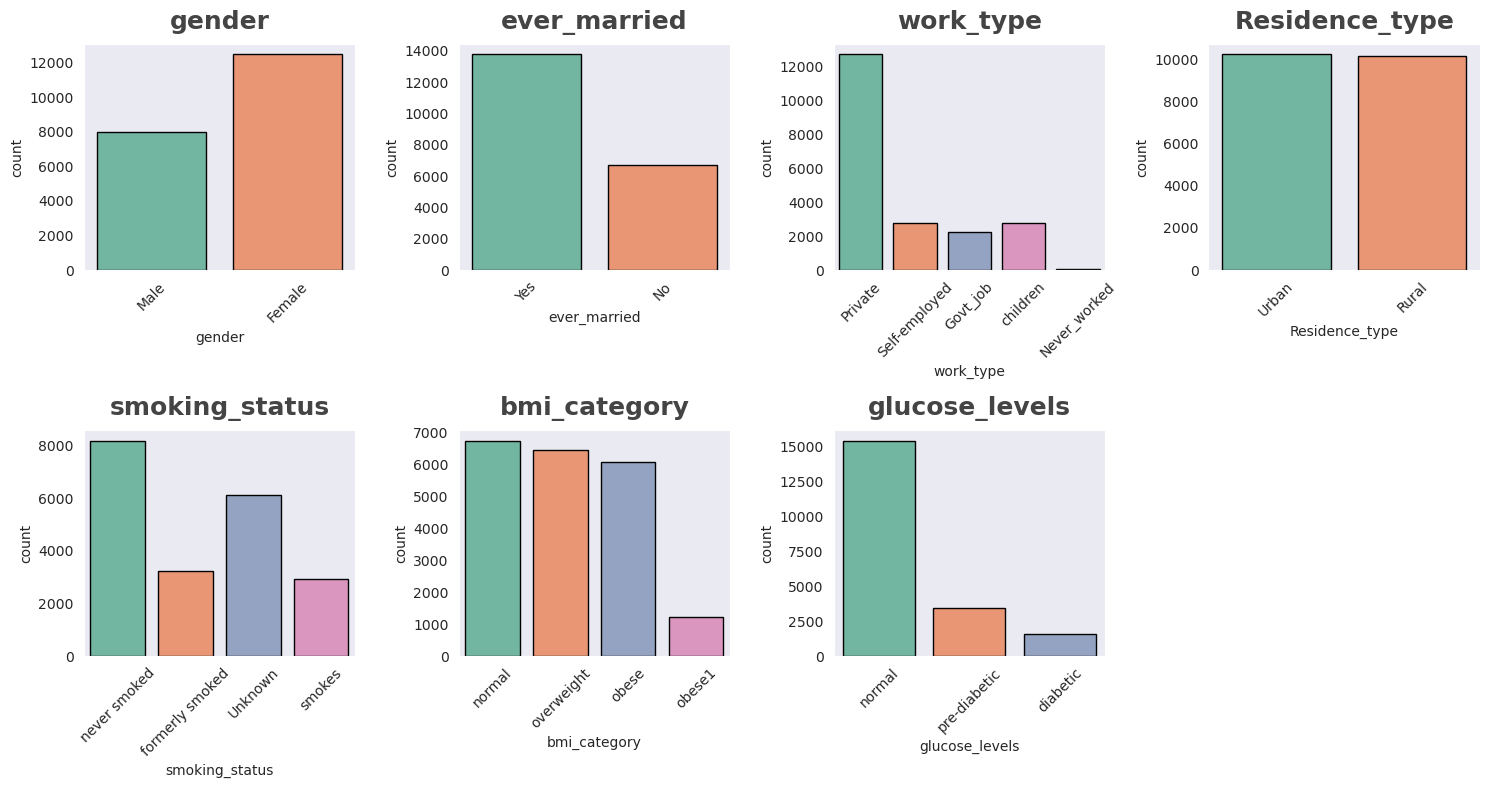

In [22]:
# Create a new figure with 2 rows and 4 columns of subplots
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

# Loop through each categorical feature and create a countplot on the corresponding subplot
for i, feat in enumerate(cat_features):
    # Calculate the row and column indices for the subplot
    row_idx, col_idx = divmod(i, 4)
    
    # Create a countplot on the current subplot
    sns.countplot(x=feat, data=df, palette='Set2', edgecolor='black', ax=axs[row_idx, col_idx])

    # Set the title for the current subplot
    axs[row_idx, col_idx].set_title(feat, size=18, y=1.03, fontname='Calibri',
                                    fontweight='bold', color='#444444')
    
    # rotate the class labels
    axs[row_idx, col_idx].set_xticklabels(axs[row_idx, col_idx].get_xticklabels(), rotation=45)

# hide last empty plot
fig.delaxes(axs[1][3])


# Add some padding between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
# apply one hot encoding to all categorical features
df = pd.get_dummies(data=df, columns=cat_features)
test_df = pd.get_dummies(data=test_df, columns=cat_features)

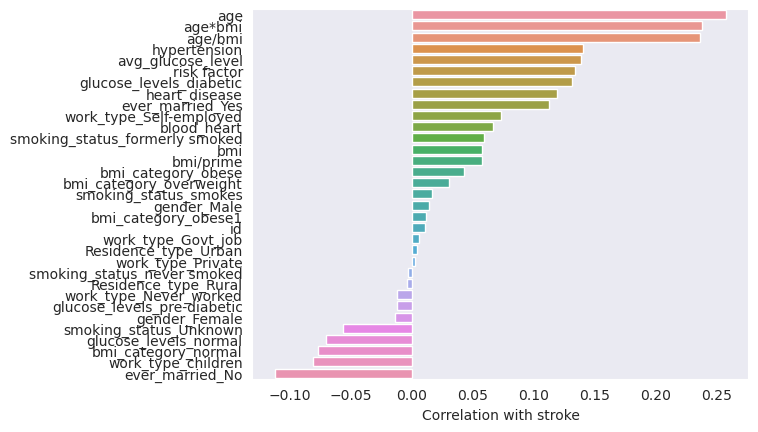

In [24]:
# Calculate the correlation between each feature and the target variable ("stroke")
corr = df.corr()["stroke"].sort_values(ascending=False) 
# Remove the correlation value for the target variable itself, as it is always 1.0
corr.drop("stroke", inplace=True) 

sns.barplot(x=corr, y=corr.index) # Create a bar plot to visualize the correlations
plt.xlabel('Correlation with stroke') # Add a label to the x-axis of the plot
plt.show()


In [25]:
df

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,risk factor,age/bmi,age*bmi,...,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,bmi_category_normal,bmi_category_overweight,bmi_category_obese,bmi_category_obese1,glucose_levels_normal,glucose_levels_pre-diabetic,glucose_levels_diabetic
0,0,28.0,0,0,79.53,31.100000,0,0,0.900322,870.800000,...,0,1,0,0,0,1,0,1,0,0
1,1,33.0,0,0,78.44,30.068182,0,1,1.097506,992.250000,...,1,0,0,0,0,1,0,1,0,0
2,2,42.0,0,0,103.00,40.300000,0,0,1.042184,1692.600000,...,0,0,0,0,0,0,1,0,1,0
3,3,56.0,0,0,64.87,28.800000,0,0,1.944444,1612.800000,...,0,1,0,0,1,0,0,1,0,0
4,4,24.0,0,0,73.36,28.800000,0,0,0.833333,691.200000,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.75,28.192157,0,1,2.837669,2255.372549,...,0,1,0,0,1,0,0,1,0,0
5106,44873,81.0,0,0,125.20,40.000000,0,0,2.025000,3240.000000,...,0,1,0,0,0,1,0,0,1,0
5107,19723,35.0,0,0,82.99,30.600000,0,0,1.143791,1071.000000,...,0,1,0,0,0,1,0,1,0,0
5108,37544,51.0,0,0,166.29,25.600000,0,1,1.992188,1305.600000,...,1,0,0,0,1,0,0,0,0,1


## Outlier Detection

age
Rejection 0 points


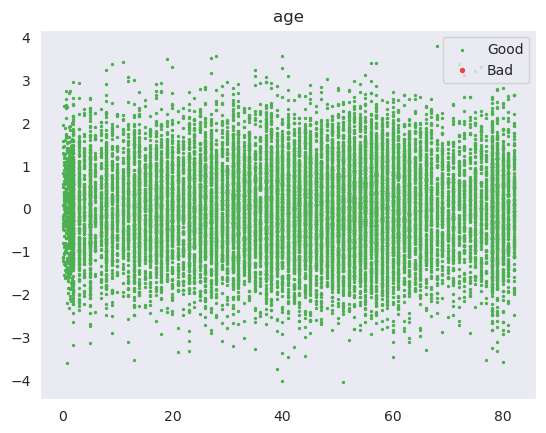

avg_glucose_level
Rejection 0 points


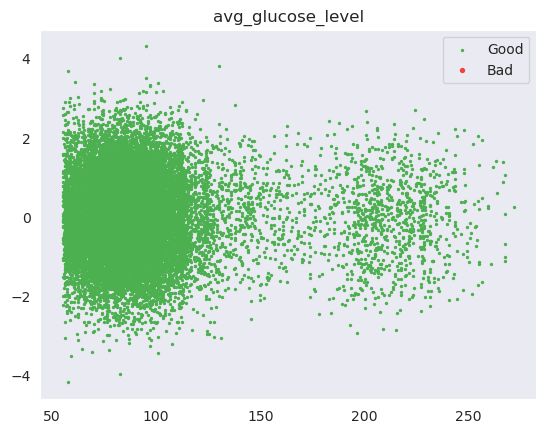

age/bmi
Rejection 1 points


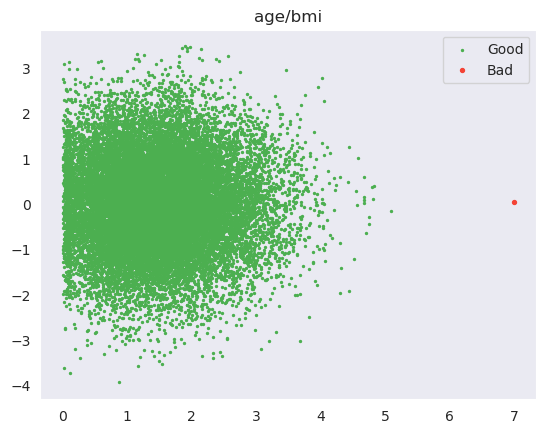

bmi
Rejection 5 points


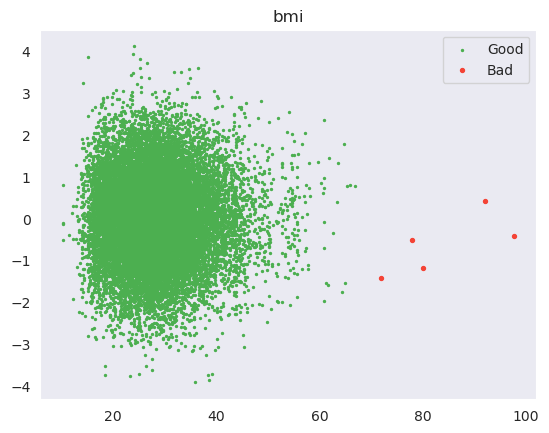

age*bmi
Rejection 0 points


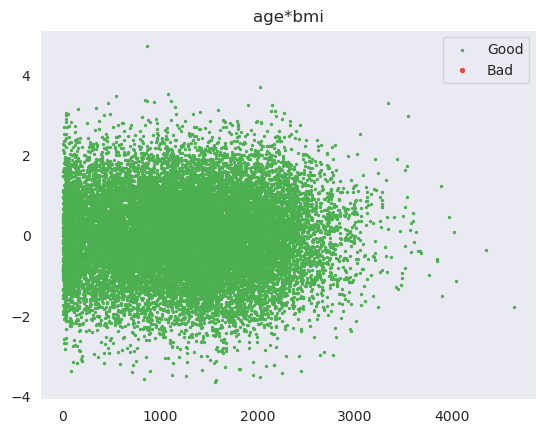

bmi/prime
Rejection 0 points


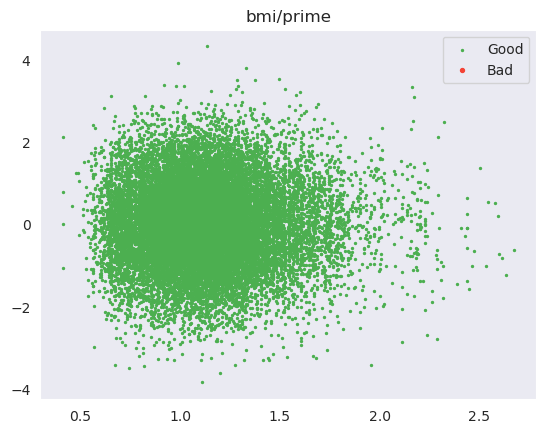

Total rows discarded: 6


In [26]:
# Define a list of continuous features to analyze for outliers
cont_FEATURES = [
    "age",
    "avg_glucose_level",
    "age/bmi",
    "bmi",
    "age*bmi",
    "bmi/prime",
]

# Define a function to plot outliers for a given feature
def plot_outliers(data,target,df, feature, threshold=6):
    mean, std = np.mean(df), np.std(df)  # Calculate the mean and standard deviation of the data
    z_score = np.abs((df-mean) / std)   # Calculate the z-score for each data point
    good = z_score < threshold # Identify data points that are more than the threshold number of standard deviations from the mean
    
    # Print the number of points that are being rejected as outliers
    print(f"Rejection {(~good).sum()} points")
    
    # Create a scatter plot to visualize the outliers
    visual_scatter = np.random.normal(size=df.size)
    plt.scatter(df[good], visual_scatter[good], s=2, label="Good", color="#4CAF50")
    plt.scatter(df[~good], visual_scatter[~good], s=8, label="Bad", color="#F44336")
    plt.legend(loc='upper right')
    plt.title(feature)
    plt.show();
    
    
    data,target = data[good],target[good] # Remove the rejected points from the input and target data
    bad_indexes = np.where(~good)[0] # Record the indexes of the rejected points
    return data, target, bad_indexes

X = df.drop(["id", "stroke"], axis=1) # Remove the "id" and "stroke" columns from the DataFrame to create the input data
y = df["stroke"] # Extract the "stroke" column as the target variable


bad_indexes = [] # Initialize a list to record the indexes of rejected points for all features

# Loop over all continuous features and plot outliers for each one
for feature in cont_FEATURES:
    print(feature)        
    X,y, bad_idx = plot_outliers(X,y,X[feature], feature, threshold=6)
    bad_indexes.extend(bad_idx)

print("Total rows discarded:", len(bad_indexes))  # Print the total number of rejected points


# Reset the indexes of the input and target data after removing outliers
X=X.reset_index(drop=True)
y=y.reset_index(drop=True)


## Feature Importance

In [27]:
# Define a function to compute MI scores between features X and target variable y
def make_mi_scores(X, y, discrete_features):
    # Compute MI scores using the mutual_info_regression function from sklearn library
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    # Convert the MI scores to a Pandas Series with column names of X as index
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    # Sort the MI scores in descending order
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# Compute the Boolean array indicating whether each feature in X is of integer type or not
discrete_features = X[X.columns.difference(num_cols)].dtypes == int 

# Call the make_mi_scores function with non-numerical columns of X, y, and discrete_features as arguments
mi_scores = make_mi_scores(X[X.columns.difference(num_cols)], y, discrete_features)

mi_scores


age*bmi                           0.036032
age/bmi                           0.032131
gender_Female                     0.013818
bmi/prime                         0.013082
ever_married_Yes                  0.012244
work_type_children                0.010530
ever_married_No                   0.009950
work_type_Govt_job                0.009432
hypertension                      0.008737
glucose_levels_normal             0.008325
risk factor                       0.008270
heart_disease                     0.005195
work_type_Private                 0.005097
glucose_levels_diabetic           0.005090
work_type_Never_worked            0.004256
glucose_levels_pre-diabetic       0.003539
Residence_type_Rural              0.003518
bmi_category_overweight           0.002510
smoking_status_Unknown            0.002234
blood_heart                       0.000329
Residence_type_Urban              0.000000
gender_Male                       0.000000
bmi_category_obese1               0.000000
bmi_categor

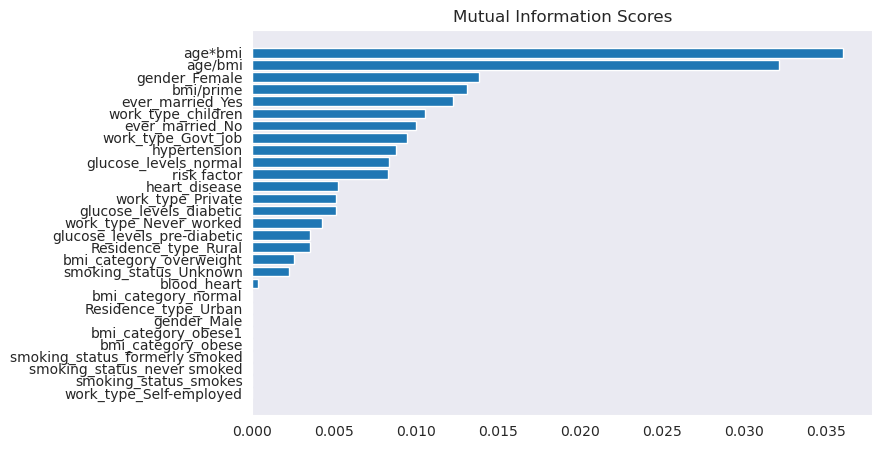

In [28]:
# Define a function to plot the MI scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True) # Sort the MI scores in ascending order
    width = np.arange(len(scores)) # Create an array of the same length as the scores, to be used as the horizontal axis
    ticks = list(scores.index) # Create a list of feature names to be used as y-axis ticks
    plt.barh(width, scores)  # Create a horizontal bar plot of the MI scores, using the width array as the x-axis and the scores as the y-axis
    plt.yticks(width, ticks)   # Set the y-axis ticks to be the feature names
    plt.title("Mutual Information Scores")  # Set the plot title to "Mutual Information Scores"


plt.figure(dpi=100, figsize=(8, 5)) # arrange the dpi and figsize
plot_mi_scores(mi_scores) # Call the plot_mi_scores function with mi_scores as the input argument


In [29]:
# drop_list=mi_scores[mi_scores==0].index

drop_list=[] # Create an empty list to store the features with MI scores equal to zero
X = X.drop(drop_list,axis=1).copy()  # Remove the features with MI scores equal to zero from the training data
test_df = test_df.drop(drop_list,axis=1).copy()  # Remove the same features from the test data


## Split into train and validation

In [30]:
# lets prepare the training and validation data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=42)


## Models

### Neural Network with Keras

In [31]:

input_shape = train_X.shape[1] # Get the number of features in the training data

# Define a neural network model using the Keras Sequential API
model = keras.Sequential([
    keras.Input(shape=input_shape),  # Add an input layer with the same number of features as the training data
    keras.layers.Dense(256, activation='relu'),  # Add a fully connected dense layer with 256 neurons and ReLU activation function
    keras.layers.Dropout(0.1),  # Add a dropout layer to prevent overfitting
    keras.layers.Dense(128, activation='relu'),  # Add another fully connected dense layer with 128 neurons and ReLU activation function
    keras.layers.Dropout(0.1),  # Add another dropout layer
    keras.layers.Dense(64, activation='relu'),  # Add another fully connected dense layer with 64 neurons and ReLU activation function
    keras.layers.Dropout(0.1),  # Add another dropout layer
    keras.layers.Dense(1, activation='sigmoid', name='output')  # Add an output layer with a single neuron and sigmoid activation function
])

# Compile the model, specifying the optimizer, loss function, and evaluation metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Define a list of callback functions to be used during training, including early stopping and model checkpointing
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=10,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_auc',
        save_best_only=True,
        mode='max'
    ),
]

# Train the model using the fit method, specifying the training and validation data, number of epochs, batch size, and callbacks
history = model.fit(
    train_X, train_y,
    validation_data=(valid_X, valid_y),
    epochs=100,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=2,
)


Epoch 1/100
511/511 - 5s - loss: 0.9934 - accuracy: 0.9234 - auc: 0.4710 - val_loss: 0.2521 - val_accuracy: 0.9535 - val_auc: 0.4245 - 5s/epoch - 10ms/step
Epoch 2/100
511/511 - 3s - loss: 0.2466 - accuracy: 0.9528 - auc: 0.5091 - val_loss: 0.1999 - val_accuracy: 0.9535 - val_auc: 0.5200 - 3s/epoch - 5ms/step
Epoch 3/100
511/511 - 2s - loss: 0.2064 - accuracy: 0.9562 - auc: 0.5564 - val_loss: 0.1943 - val_accuracy: 0.9535 - val_auc: 0.5163 - 2s/epoch - 4ms/step
Epoch 4/100
511/511 - 2s - loss: 0.1941 - accuracy: 0.9569 - auc: 0.5875 - val_loss: 0.1867 - val_accuracy: 0.9535 - val_auc: 0.6073 - 2s/epoch - 4ms/step
Epoch 5/100
511/511 - 2s - loss: 0.1819 - accuracy: 0.9574 - auc: 0.6499 - val_loss: 0.1768 - val_accuracy: 0.9535 - val_auc: 0.7271 - 2s/epoch - 4ms/step
Epoch 6/100
511/511 - 2s - loss: 0.1687 - accuracy: 0.9575 - auc: 0.7011 - val_loss: 0.1650 - val_accuracy: 0.9535 - val_auc: 0.8004 - 2s/epoch - 5ms/step
Epoch 7/100
511/511 - 2s - loss: 0.1603 - accuracy: 0.9576 - auc: 0.7

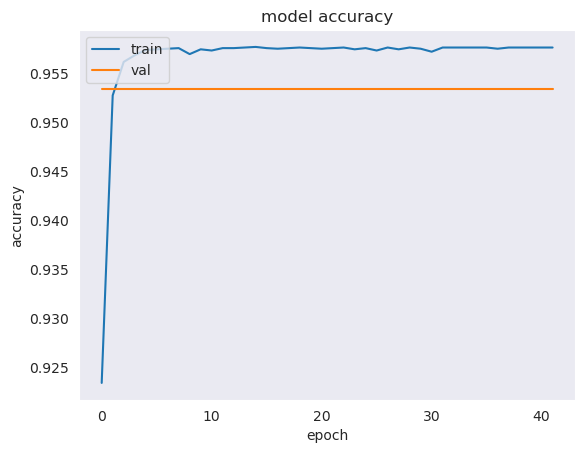

In [32]:
# Plot the training and validation accuracy over the course of training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

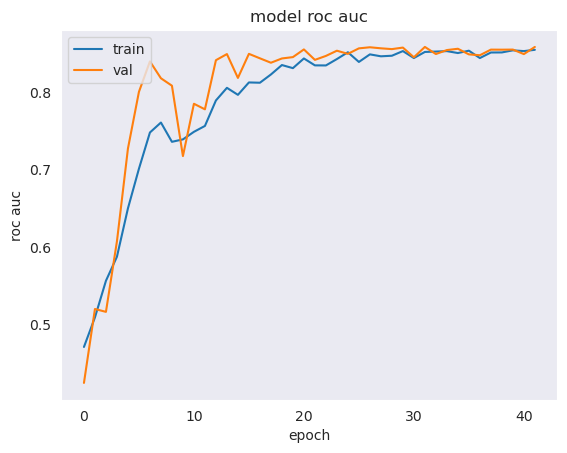

In [33]:
# Plot the training and validation ROC AUC score over the course of training
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model roc auc')
plt.ylabel('roc auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
# load back best model
nn_model = keras.models.load_model('best_model.h5')

### GBoost Model

In [35]:
# Define the best hyperparameters for Gradient Boosting obtained through hyperparameter tuning
best_parameters_gboost = {'ccp_alpha': 0.0, 'learning_rate': 0.05, 'n_estimators': 100, 'n_iter_no_change': 100, 'tol': 0.0001, 'validation_fraction': 0.2}

# Train a Gradient Boosting model using the best hyperparameters
gboost_model = GradientBoostingClassifier(random_state=seed, **best_parameters_gboost)
gboost_model.fit(train_X, train_y)


GradientBoostingClassifier(learning_rate=0.05, n_iter_no_change=100,
                           random_state=42, validation_fraction=0.2)

### Lasso model

In [36]:
# # We are discarding lasso model because without it we get better results in ensemble model
# from sklearn.linear_model import Lasso

# #Define the hyperparameters for Lasso
# lasso_hyperparameters = {
#     'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
#     'max_iter': [10000, 1000, 5000],
#     'tol': [0.0001, 0.0005, 0.001, 0.005, 0.01],
#     'selection': ['cyclic', 'random'],
#     'warm_start': [True, False],
#     'random_state': [seed],
# }

# # grid_search = GridSearchCV(Lasso(), lasso_hyperparameters, cv=5, n_jobs=-1, verbose=1)
# # grid_search.fit(train_X, train_y)
# # print(grid_search.best_params_)

# #Define the best hyperparameters for Lasso model
# best_hyperparameters_lasso = {'alpha': 0.0005, 'max_iter': 10000, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.01, 'warm_start': True}

# #Train Lasso model with the best hyperparameters on the training data
# lasso_model = Lasso(**best_hyperparameters_lasso)
# lasso_model.fit(train_X, train_y)

### LGBM

In [37]:
# lets train lgbm
from lightgbm import LGBMClassifier

lgbm_hyperparameters = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2,],
    'num_leaves': [2, 6, 10, 14, 18, 20],
    'max_depth': [2, 6, 8,  12,  16,  20],
    'min_child_samples': [2, 4,  8, 12, 16,  20],
    'subsample': [0.5, 0.6, 0.8, 1],
}
# clf = LGBMClassifier(random_state=seed, n_jobs=-1)
# grid_search = GridSearchCV(clf, lgbm_hyperparameters, cv=5, n_jobs=-1, verbose=1)
# grid_search.fit(train_X, train_y)
# print(grid_search.best_params_)

best_params_lgbm = {'learning_rate': 0.05, 'max_depth': 6, 'min_child_samples': 12, 'n_estimators': 100, 'num_leaves': 6, 'subsample': 0.5}
lgbm_model = LGBMClassifier(random_state=seed, n_jobs=-1, **best_params_lgbm)
lgbm_model.fit(train_X, train_y)


LGBMClassifier(learning_rate=0.05, max_depth=6, min_child_samples=12,
               num_leaves=6, random_state=42, subsample=0.5)

### CatBoost

In [38]:
# # We discarded this model too
# from catboost import CatBoostClassifier
# catboost_model = CatBoostClassifier(
#     iterations=1000,
#     learning_rate=0.1,
#     eval_metric="AUC",
#     random_seed=seed,
#     od_type="Iter",
#     metric_period=50,
# #     task_type="GPU",
# #     devices="0:1",
#     verbose=100,
# )

# catboost_model.fit(
#     train_X, train_y,
# #     cat_features=["gender", "ever_married", "work_type", "Residence_type", "smoking_status"],
#     eval_set=(valid_X, valid_y),
#     use_best_model=True,
#     plot=True,
# )


## Ensemble

In [39]:
test_df.drop(["id"], axis=1,inplace=True) # drop the ID column

# we are taking the average of the model predictions
# as an ensemble technique
predictions = [
    gboost_model.predict_proba(test_df)[:, 1],
    nn_model.predict(test_df).flatten(),
    lgbm_model.predict_proba(test_df)[:, 1],
#     catboost_model.predict_proba(test_df)[:, 1], # you can reintegrate these models by just uncommenting them
#     lasso_model.predict(test_df),
]

# take the average of the predictions
ensemble_predictions = np.mean(predictions, axis=0)


319/319 [==============================] - 1s 2ms/step


## Save the predictions

In [40]:
# save submission
submission = pd.read_csv("/kaggle/input/playground-series-s3e2/sample_submission.csv")
submission["stroke"] = ensemble_predictions
submission.to_csv("submission.csv", index=False)